### Import Necessary Libraries

In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/early-stage-diabetes-risk-prediction/diabetes_risk_prediction_dataset.csv


### Read dataset

In [42]:
df = pd.read_csv("/kaggle/input/early-stage-diabetes-risk-prediction/diabetes_risk_prediction_dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

### Check for NA values

Luckily, in this dataset we don't have any NA (missing) values.

In [43]:
display(df.head())
df.isna().sum()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

### EDA

Let's check the distributions of each variable, and preliminarily check which variables might make good predictors.

In [44]:
# Import libraries

import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
# {1 : 'Male', 0 : 'Female'}

df['Diabetes'] = (df['class'] == 'Positive').astype(int)

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = ((df[col] == 'Yes') | (df[col] == 'Male')).astype(int)

df.drop(columns=['class'], inplace=True)

In [46]:
df.head(5)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,Diabetes
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


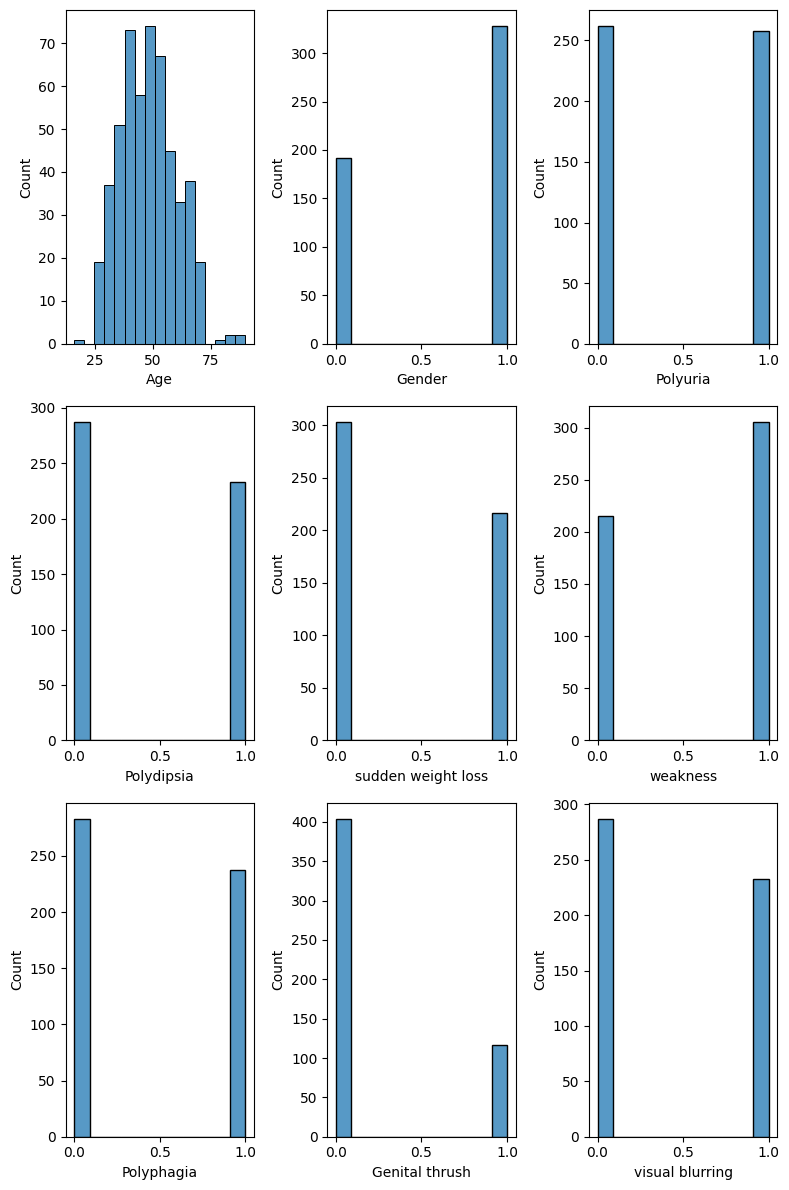

In [47]:
fig, axes = plt.subplots(3, 3, figsize=(8, 12))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    if i == 9:
        break
    sns.histplot(df, x=col, ax=axes[i])
    
plt.tight_layout()
plt.show;

### Second half of variables

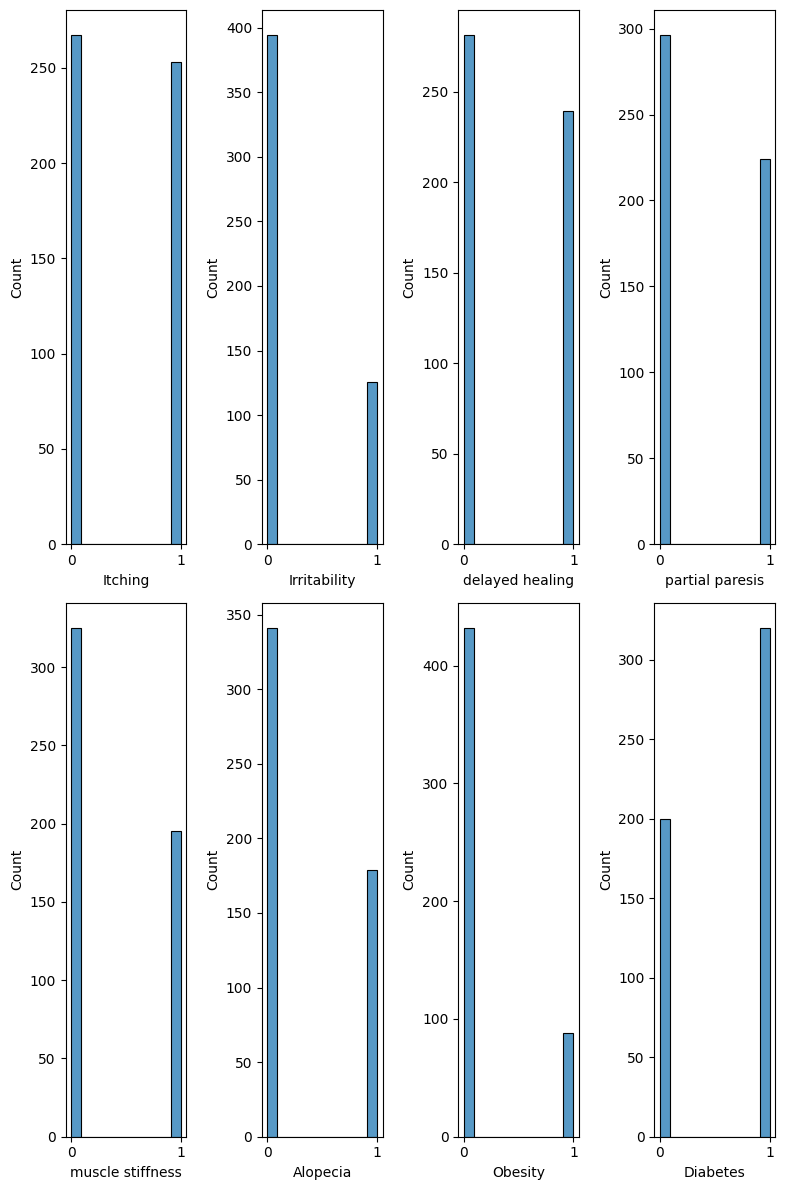

In [48]:
fig, axes = plt.subplots(2, 4, figsize=(8, 12))
axes = axes.flatten()

for i, col in enumerate(df.columns[9:]):
    sns.histplot(df, x=col, ax=axes[i])
    
plt.tight_layout()
plt.show;

### Let's make a heatmap

This should help us select the "best" features for our model.

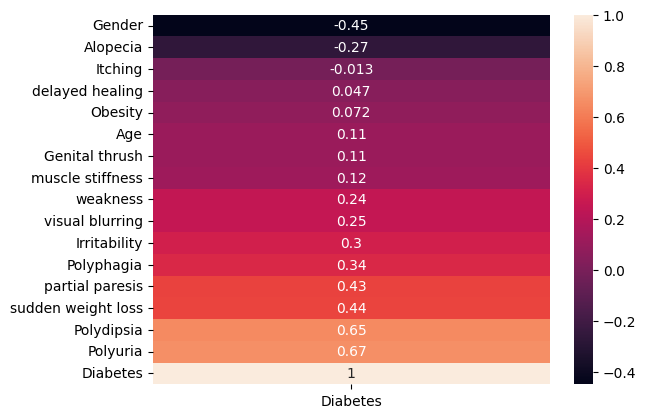

In [49]:
# Correlation Heatmap

sns.heatmap(df.corr()['Diabetes'].sort_values().to_frame(), annot=True);

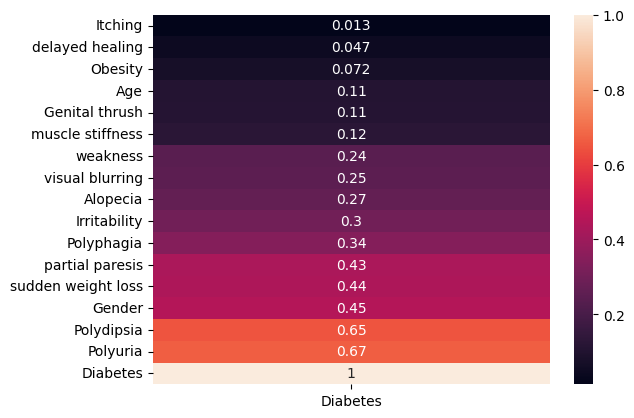

In [50]:
# Absolute Valued Correlation Heatmap

sns.heatmap(df.corr()['Diabetes'].abs().sort_values().to_frame(), annot=True);

### Immediately

We notice that we have a lot of great options for model features. 

For some additional context, "Polyuria" is excessive urination and "Polydipsia" is excessive thirst. In my experience, these are both things I've heard to watch out for when suspecting a diabetes diagnosis. Also note that "Gender" is the 3rd best predictor, with women being more likely to have the condition than men. 

Let's drop the variables with the lowest absolute value correlation.

In [51]:
df.drop(columns=['Itching', 'delayed healing'], inplace=True)
df.columns

Index(['Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss',
       'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
       'Irritability', 'partial paresis', 'muscle stiffness', 'Alopecia',
       'Obesity', 'Diabetes'],
      dtype='object')

### Let's start modeling!

First though is to use logistic regression for this classification model.

In [52]:
X_train, X_val, y_train, y_val = \
train_test_split(df.drop(columns='Diabetes'), df['Diabetes'], test_size=0.2)

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)
model.coef_

array([[-0.03746774, -2.72027791,  2.27733972,  2.93889277,  0.43049706,
         0.07100546,  0.92348137,  0.89321755, -0.11195138,  1.40741862,
         1.0654443 , -0.63212832, -0.23588413, -0.05478162]])

In [54]:
train_prediction = model.predict(X_train)
val_prediction = model.predict(X_val)

train_accuracy = np.mean(train_prediction == y_train)
val_accuracy = np.mean(val_prediction == y_val)

print(f'Model training accuracy: {train_accuracy} \nModel validation accuracy: {val_accuracy}')

Model training accuracy: 0.9302884615384616 
Model validation accuracy: 0.9038461538461539


### Precision vs Recall

Let's attain and interpret the precision and recall of our model on the validation data.

In [55]:
print('Confusion Matrix\n')
confusion_matrix(y_val, val_prediction)

Confusion Matrix



array([[40,  6],
       [ 4, 54]])

In [56]:
tn, fp, fn, tp = confusion_matrix(y_val, val_prediction).ravel()

model_precision = tp / (tp + fp)
model_recall = tp / (tp + fn)

print(f'Model Precision: {model_precision}\nModel Recall: {model_recall}')

Model Precision: 0.9
Model Recall: 0.9310344827586207


### Assessment

These are great numbers, but since we're dealing with a diagnosis, we want to err on the size of caution, and prioritize maximizing our recall score (minimize false negatives). Let's attempt this and see how it affects our accuracy.

In [57]:
probs = model.predict_proba(X_val)
thresholds = np.linspace(0, 1, 100)
optimal_threshold = 0.5
tn, fp, fn, tp = 0, 0, 0, 0

for threshold in thresholds:
    if fn > 0:
        optimal_threshold = threshold - 0.02
        predictions = (probs[:,1] >= optimal_threshold).astype('int')
        break
    predictions = (probs[:,1] >= threshold).astype('int')
    fn = ((predictions != y_val) & (predictions == 0)).sum()
    
tn, fp, fn, tp = confusion_matrix(y_val, predictions).ravel()

adj_precision = tp / (tp + fp)
adj_recall = tp / (tp + fn)
adj_accuracy = (tp + tn) / (tp + tn + fp + fn)

print(f'New model threshold: {optimal_threshold}')
print(f'Model Precision: {adj_precision}\nModel Recall (should be one): {adj_recall}')
print(f'Model Validation Accuracy: {adj_accuracy}')

New model threshold: 0.25272727272727274
Model Precision: 0.7945205479452054
Model Recall (should be one): 1.0
Model Validation Accuracy: 0.8557692307692307


### Assessment

Unfortunately, if we want to have perfect recall, we make a large sacrifice to the validation accuracy. Therefore it would perhaps be best to leave the model as it stands. However, it might be better to use a random forest classifier because the data aren't linearly seperable like in the optimal logistic regression case.

### Random Forest Algorithm

In [58]:
from sklearn.ensemble import RandomForestClassifier

m2 = RandomForestClassifier(random_state=42)
m2.fit(X_train, y_train)

m2.estimators_[:3]

[DecisionTreeClassifier(max_features='sqrt', random_state=1608637542),
 DecisionTreeClassifier(max_features='sqrt', random_state=1273642419),
 DecisionTreeClassifier(max_features='sqrt', random_state=1935803228)]

In [59]:
m2_val_prediction = m2.predict(X_val)

tn, fp, fn, tp = confusion_matrix(y_val, m2_val_prediction).ravel()

print('Confusion Matrix\n')
display(confusion_matrix(y_val, m2_val_prediction))
print()

m2_train_prediction = m2.predict(X_train)

m2_precision = tp / (tp + fp)
m2_recall = tp / (tp + fn)
m2_accuracy = (tp + tn) / (tp + tn + fp + fn)
m2_train_accuracy = (m2_train_prediction == y_train).mean()

print(f'Model Precision: {m2_precision}\nModel Recall: {m2_recall}')
print(f'Model Training Accuracy: {m2_train_accuracy}\nModel Validation Accuracy: {m2_accuracy}')

Confusion Matrix



array([[44,  2],
       [ 0, 58]])


Model Precision: 0.9666666666666667
Model Recall: 1.0
Model Training Accuracy: 1.0
Model Validation Accuracy: 0.9807692307692307


### Conclusion

We've achieved a model with high accuracy (>95%) and a high recall (>95%) on available validation data using the random forest algorithm.

In [60]:
# Saving model
import joblib as jl

jl.dump(m2, 'final_model.pkl')

['final_model.pkl']